In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from models.NeuralNetwork import NeuralNetwork

In [2]:
filename = "adult.csv"
data = read_csv(filename,delimiter=",", na_values="?")

#class_counts = data.groupby('income').size()
#print(class_counts)

"""
Imputation
"""
null_columns =['workclass','occupation','native.country']
for i in null_columns:
    data.fillna(data[i].mode()[0], inplace=True)
    
"""
Factorize
"""  
data['income'] = data['income'].replace({'<=50K':0, '>50K':1})
data['sex'] = data['sex'].replace({'Female':0, 'Male':1})
data['race'] = data['race'].replace({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Other':3,'Amer-Indian-Eskimo':4})
data['workclass'] = data['workclass'].replace({'Private':0, 'State-gov':1, 'Federal-gov':2, 'Self-emp-not-inc':3,
       'Self-emp-inc':4, 'Local-gov':5, 'Without-pay':6, 'Never-worked':7})
data['native.country'] = data['native.country'].replace({'United-States':0, 'Private':1, 'Mexico':2, 'Greece':3, 'Vietnam':4, 'China':5,
       'Taiwan':6, 'India':7, 'Philippines':8, 'Trinadad&Tobago':9, 'Canada':10,
       'South':11, 'Holand-Netherlands':12, 'Puerto-Rico':13, 'Poland':14, 'Iran':15,
       'England':16, 'Germany':17, 'Italy':18, 'Japan':19, 'Hong':20, 'Honduras':21, 'Cuba':22,
       'Ireland':23, 'Cambodia':24, 'Peru':25, 'Nicaragua':26, 'Dominican-Republic':27,
       'Haiti':28, 'El-Salvador':29, 'Hungary':30, 'Columbia':31, 'Guatemala':32,
       'Jamaica':33, 'Ecuador':34, 'France':35, 'Yugoslavia':36, 'Scotland':37,
       'Portugal':38, 'Laos':39, 'Thailand':40, 'Outlying-US(Guam-USVI-etc)':41})
data['occupation'] = data['occupation'].replace({'Private':0, 'Exec-managerial':1, 'Machine-op-inspct':2,
       'Prof-specialty':3, 'Other-service':4, 'Adm-clerical':5, 'Craft-repair':6,
       'Transport-moving':7, 'Handlers-cleaners':8, 'Sales':9,
       'Farming-fishing':10, 'Tech-support':11, 'Protective-serv':12,
       'Armed-Forces':13, 'Priv-house-serv':14})
data['relationship'] = data['relationship'].replace({'Not-in-family':0, 'Unmarried':1, 'Own-child':2, 'Other-relative':3,
       'Husband':4, 'Wife':5})
data['education'] = data['education'].replace({'HS-grad':0, 'Some-college':1, '7th-8th':2, '10th':3, 'Doctorate':4,
       'Prof-school':5, 'Bachelors':6, 'Masters':7, '11th':8, 'Assoc-acdm':9,
       'Assoc-voc':10, '1st-4th':11, '5th-6th':12, '12th':13, '9th':14, 'Preschool':15})
data['marital.status'] = data['marital.status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'], 'Single')
data['marital.status'] = data['marital.status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
data['marital.status'] = data['marital.status'].map({'Married':1, 'Single':0})


X = data.iloc[:,:14]
y = data.iloc[:,14]

"""
Undersample
"""  
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X,y)

"""
Scaling
""" 
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

"""
Splitting
"""

X_train, X_test, y_train, y_test = train_test_split(rescaledX,y.to_numpy(),test_size=0.2, random_state=1)


In [3]:
def sample_batch(data,batch_size):
    st_batch = data.shape[0] // batch_size
    idx_end = st_batch * batch_size
    batch = np.split(data[:idx_end], st_batch)
    
    if data.shape[0] % batch_size != 0:
        batch += [data[idx_end:]]
    
    return batch

In [60]:
from sklearn.model_selection import StratifiedKFold

def ml_model(X_train, y_train, model, optimizer, opt_attr, batch_size = 128, epochs = 100, folds = 10):
    
    splits = StratifiedKFold(n_splits = folds, shuffle = True)
    
    log = []
    it = 1
    for fold, (train_idx, valid_idx) in enumerate(splits.split(X_train, y_train)):
        print("Fold:", fold+1)
                    
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train[valid_idx]

        for t in range(epochs):
        
            train_loss, train_acc = [], []
            valid_loss, valid_acc = [], []  

            X_t_batch = sample_batch(X_train_fold, batch_size)
            y_t_batch = sample_batch(y_train_fold, batch_size)

            X_v_batch = sample_batch(X_valid_fold, batch_size)
            y_v_batch = sample_batch(y_valid_fold, batch_size)

            for Xs, ys in zip(X_t_batch, y_t_batch):
                                
                nn.forward(Xs)
                _, running_loss = nn.b_cross_entropy(ys, nn.A3)
                train_loss.append(running_loss)
                
                _, _, running_acc = nn.predict(Xs,ys)
                train_acc.append(running_acc)
                
                nn.backward(ys, nn.db_cross_entropy)
                optimizer(attr=opt_attr)

            
            epoch_train_loss = sum(train_loss) / len(train_loss)
            epoch_train_acc = sum(train_acc) / len(train_acc)
            
            
           
            for Xs, ys in zip(X_v_batch, y_v_batch):            
                
                probs, _, running_acc = nn.predict(Xs,ys)
                _, running_loss = nn.b_cross_entropy(ys, probs)
                valid_loss.append(running_loss)
                valid_acc.append(running_acc)
             
            epoch_valid_loss = sum(valid_loss) / len(valid_loss)
            epoch_valid_acc = sum(valid_acc) / len(valid_acc)
            
            if t % 2 == 0:
                print("Epoch: {:02d} - Loss: {:.4f} - Acc: {:.4f} - ".format(t, epoch_train_loss, epoch_train_acc), end="")
                print("Val_Loss: {:.4f} - Val_Acc: {:.4f}".format(epoch_valid_loss, epoch_valid_acc))  
            
            log.append([it, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc])
            it += 1
    return pd.DataFrame(log, columns=["epochs","T Loss","T Accuracy","V Loss", "V Accuracy"])
            
            

In [61]:
# Change number of hidden nodes
nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.gd, 
                opt_attr = {"lr":0.01},
                batch_size = 128,
                epochs = 10,
                folds = 7)

Fold: 1
Epoch: 00 - Loss: 0.5996 - Acc: 72.5818 - Val_Loss: 0.5087 - Val_Acc: 77.1354
Epoch: 02 - Loss: 0.4788 - Acc: 76.9810 - Val_Loss: 0.4468 - Val_Acc: 79.5833
Epoch: 04 - Loss: 0.4488 - Acc: 78.6458 - Val_Loss: 0.4358 - Val_Acc: 81.0938
Epoch: 06 - Loss: 0.4400 - Acc: 79.2690 - Val_Loss: 0.4358 - Val_Acc: 81.0417
Epoch: 08 - Loss: 0.4356 - Acc: 79.5015 - Val_Loss: 0.4349 - Val_Acc: 81.0417
Fold: 2
Epoch: 00 - Loss: 0.4354 - Acc: 79.6599 - Val_Loss: 0.4125 - Val_Acc: 80.5804
Epoch: 02 - Loss: 0.4325 - Acc: 79.8529 - Val_Loss: 0.4108 - Val_Acc: 80.7478
Epoch: 04 - Loss: 0.4304 - Acc: 80.0460 - Val_Loss: 0.4090 - Val_Acc: 80.8594
Epoch: 06 - Loss: 0.4285 - Acc: 80.0919 - Val_Loss: 0.4074 - Val_Acc: 80.9152
Epoch: 08 - Loss: 0.4268 - Acc: 80.1746 - Val_Loss: 0.4059 - Val_Acc: 80.9710
Fold: 3
Epoch: 00 - Loss: 0.4206 - Acc: 80.3676 - Val_Loss: 0.4378 - Val_Acc: 79.6875
Epoch: 02 - Loss: 0.4189 - Acc: 80.4779 - Val_Loss: 0.4371 - Val_Acc: 79.6875
Epoch: 04 - Loss: 0.4173 - Acc: 80.5239 

Text(0, 0.5, 'Val. Accuracy')

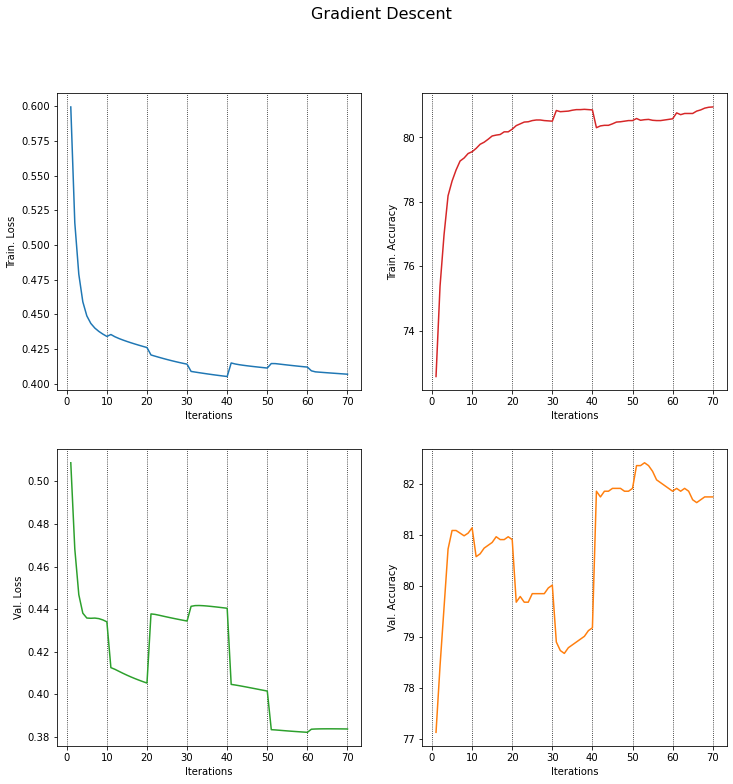

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

fig.suptitle("Gradient Descent", fontsize=16)
ax1.plot(log["epochs"],log["T Loss"], c="tab:blue")
ax1.xaxis.grid(True,linestyle=":",color='black')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Train. Loss")

ax2.plot(log["epochs"],log["T Accuracy"], c="tab:red")
ax2.xaxis.grid(True,linestyle=":",color='black')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Train. Accuracy")

ax3.plot(log["epochs"],log["V Loss"], c="tab:green")
ax3.xaxis.grid(True,linestyle=":",color='black')
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Val. Loss")

ax4.plot(log["epochs"],log["V Accuracy"], c="tab:orange")
ax4.xaxis.grid(True,linestyle=":",color='black')
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Val. Accuracy")


In [44]:
_, prediction, accuracy = nn.predict(X_test,y_test)
print(prediction)
print(accuracy)

[1. 1. 0. ... 0. 1. 1.]
81.31973222824355
